# ORF recognition by Convolutional/Recurrent

Test CNN+GRU 32 on simulated RNA of length 128. 

Use restructured codebase from notebook 105.

In [15]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-22 12:58:39 UTC'

In [16]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=128            # how long is each sequence
CDS_LEN=64            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 64   # how many different patterns the model looks for
CELLS = 64
NEURONS = 64
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [17]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [18]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [19]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 41 trials to reach 10 per class.
It took 116183 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [20]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 128.0
Average ORF length: 78.9489090909091
NC seqs
Average RNA length: 128.0
Average ORF length: 27.635636363636365


In [21]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [22]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [23]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(GRU(CELLS,return_sequences=True))
    dnn.add(GRU(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (128, 4)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 128, 64)           832       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 128, 64)           12352     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 64, 64)            0         
_________________________________________________________________
gru_8 (GRU)                  (None, 64, 64)            24960     
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)    

In [24]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 16s 10ms/step - loss: 0.7030 - accuracy: 0.5217 - val_loss: 0.6536 - val_accuracy: 0.6144


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6434 - accuracy: 0.6275 - val_loss: 0.6310 - val_accuracy: 0.6377


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6134 - accuracy: 0.6575 - val_loss: 0.5789 - val_accuracy: 0.6861


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5734 - accuracy: 0.6921 - val_loss: 0.5775 - val_accuracy: 0.6859
Epoch 5/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5695 - accuracy: 0.6925 - val_loss: 0.5669 - val_accuracy: 0.6908


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5586 - accuracy: 0.7017 - val_loss: 0.5695 - val_accuracy: 0.6874
Epoch 7/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5473 - accuracy: 0.7077 - val_loss: 0.5658 - val_accuracy: 0.6953


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5420 - accuracy: 0.7163 - val_loss: 0.5648 - val_accuracy: 0.6909
Epoch 9/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5410 - accuracy: 0.7159 - val_loss: 0.5898 - val_accuracy: 0.6871
Epoch 10/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5305 - accuracy: 0.7252 - val_loss: 0.5822 - val_accuracy: 0.6884
Epoch 11/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5268 - accuracy: 0.7203 - val_loss: 0.5817 - val_accuracy: 0.6900
Epoch 12/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5213 - accuracy: 0.7255 - val_loss: 0.5692 - val_accuracy: 0.6906
Epoch 13/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5123 - accuracy: 0.7332 - val_loss: 0.5853 - val_accuracy: 0.6802
Epoch 14/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5053 - accuracy: 0.7389 - val_loss: 0.5

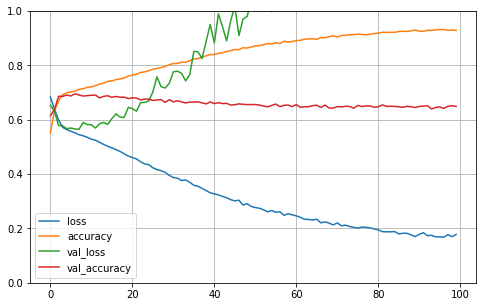

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 16s 10ms/step - loss: 0.6996 - accuracy: 0.5232 - val_loss: 0.6431 - val_accuracy: 0.6251
Epoch 2/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6444 - accuracy: 0.6237 - val_loss: 0.6055 - val_accuracy: 0.6709
Epoch 3/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5995 - accuracy: 0.6735 - val_loss: 0.5771 - val_accuracy: 0.6903
Epoch 4/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5769 - accuracy: 0.6882 - val_loss: 0.5691 - val_accuracy: 0.6956


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5662 - accuracy: 0.6967 - val_loss: 0.5691 - val_accuracy: 0.6947
Epoch 6/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5639 - accuracy: 0.6960 - val_loss: 0.5685 - val_accuracy: 0.6930
Epoch 7/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5531 - accuracy: 0.7028 - val_loss: 0.5657 - val_accuracy: 0.6956


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5436 - accuracy: 0.7087 - val_loss: 0.5670 - val_accuracy: 0.6967


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5367 - accuracy: 0.7161 - val_loss: 0.5820 - val_accuracy: 0.6862
Epoch 10/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5308 - accuracy: 0.7224 - val_loss: 0.5743 - val_accuracy: 0.6911
Epoch 11/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5213 - accuracy: 0.7221 - val_loss: 0.5829 - val_accuracy: 0.6885
Epoch 12/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5113 - accuracy: 0.7331 - val_loss: 0.5820 - val_accuracy: 0.6843
Epoch 13/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5050 - accuracy: 0.7340 - val_loss: 0.6028 - val_accuracy: 0.6828
Epoch 14/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4959 - accuracy: 0.7424 - val_loss: 0.6026 - val_accuracy: 0.6820
Epoch 15/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4870 - accuracy: 0.7455 - val_loss: 0.

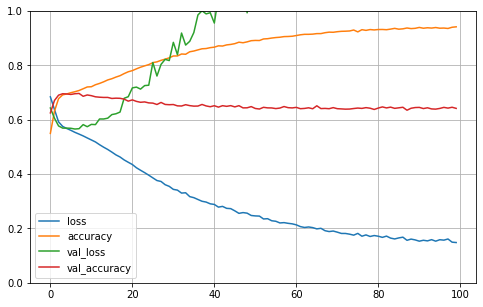

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 16s 10ms/step - loss: 0.7010 - accuracy: 0.5272 - val_loss: 0.6443 - val_accuracy: 0.6171
Epoch 2/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6408 - accuracy: 0.6275 - val_loss: 0.6012 - val_accuracy: 0.6706
Epoch 3/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5931 - accuracy: 0.6809 - val_loss: 0.5807 - val_accuracy: 0.6879
Epoch 4/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5747 - accuracy: 0.6964 - val_loss: 0.5641 - val_accuracy: 0.6943
Epoch 5/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5662 - accuracy: 0.6993 - val_loss: 0.5610 - val_accuracy: 0.6974


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5562 - accuracy: 0.7048 - val_loss: 0.5617 - val_accuracy: 0.6984


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5482 - accuracy: 0.7110 - val_loss: 0.5617 - val_accuracy: 0.6966
Epoch 8/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5448 - accuracy: 0.7132 - val_loss: 0.5617 - val_accuracy: 0.6982
Epoch 9/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5422 - accuracy: 0.7144 - val_loss: 0.5647 - val_accuracy: 0.6954
Epoch 10/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5336 - accuracy: 0.7199 - val_loss: 0.5760 - val_accuracy: 0.6887
Epoch 11/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5299 - accuracy: 0.7201 - val_loss: 0.5715 - val_accuracy: 0.6933
Epoch 12/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5155 - accuracy: 0.7309 - val_loss: 0.5723 - val_accuracy: 0.6900
Epoch 13/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5129 - accuracy: 0.7342 - val_loss: 0.58

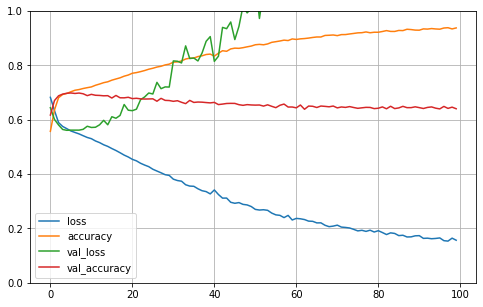

In [25]:
do_cross_validation(X,y)

In [26]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 68.50%


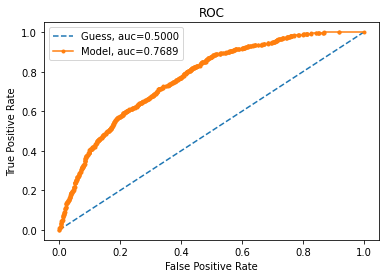

AUC: 76.89%


In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [28]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-22 14:00:54 UTC'